<a href="https://colab.research.google.com/github/ZoyPan1111/Tibame-Group-Project2021/blob/main/%E6%A8%A1%E5%9E%8B%E6%AF%94%E8%BC%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用套件

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.layers import Dropout

# preprocess_input 這邊引用各自模型
from tensorflow.keras.applications.mobilenet import preprocess_input as M_pre_input
from tensorflow.keras.applications.xception import preprocess_input as X_pre_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_pre_input

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 模型架構與讀取weights

## - 辰 model1

In [ ]:
# 放模型構架
cnn_M = MobileNet(include_top=False, input_shape=(224, 224, 3))
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model1 = Sequential(cnn_M.layers + layers)

# 直接Load model 讀取 weights
model1.load_weights('/content/drive/MyDrive/Model_Test/mobileNet_Vol.3.h5')

## - 驛 model2

In [ ]:
cnn_X = Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
# cnn_X.summary()
# 卷積模型不參與訓練，要在 compile 前設定好
for l in cnn_X.layers:
  l.trainable = False

# 加上自己的網路層
x = cnn_X.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x) 

model2 = Model(cnn_X.input, output)
#model.summary()  # Trainable params: 8,194 = 2048*2 + ( 2048*2+2 )

# 直接Load model 讀取 weights
model2.load_weights("/content/drive/MyDrive/Model_Test/poo_zoy_X1weights.h5")

83697664/83683744 [==============================] - 1s 0us/step


## - 源 model3

In [ ]:
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))

for l in cnn.layers:
    l.trainable = False

layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model3 = Sequential(cnn.layers + layers)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# 直接Load model 讀取 weights
model3.load_weights("/content/drive/MyDrive/Model_Test/poo_mike_v3weights.h5")

# 讀取測試照片集20張(正常:10/不正常:10)

In [ ]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/Model_Test/TestIMG.zip")
f.extractall()

In [ ]:
picG = glob.glob("TestIMG/good*") # 10張正常
picB = glob.glob("TestIMG/bad*") # 10張不正常

x_test = np.array(picG + picB)
y_test = np.array([0] * len(picG) + [1] * len(picB))

print(x_test.shape)
print(y_test.shape)

(20,)
(20,)


# 進行測試資料前處理

## model1

In [ ]:
ori_imgs1 = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs1.append(np.array(img))
ori_imgs1 = np.array(ori_imgs1)
preprocess_imgs1 = M_pre_input(ori_imgs1)

## model2

In [ ]:
ori_imgs2 = []
for p in x_test:
    img = Image.open(p).resize((299, 299)).convert("RGB")
    ori_imgs2.append(np.array(img))
ori_imgs2 = np.array(ori_imgs2)
preprocess_imgs2 = X_pre_input(ori_imgs2)

## model3

In [ ]:
ori_imgs3 = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs3.append(np.array(img))
ori_imgs3 = np.array(ori_imgs3)
preprocess_imgs3 = vgg16_pre_input(np.array(ori_imgs3))

# 模型預測數據

## Recall & Precision 

In [ ]:
# 三個模型預測
pre1 = model1.predict(preprocess_imgs1).argmax(axis=1)
pre2 = model2.predict(preprocess_imgs2).argmax(axis=1)
pre3 = model3.predict(preprocess_imgs3).argmax(axis=1)

print(classification_report(y_test, pre1)) # Model1 - MobileNet
print(classification_report(y_test, pre2)) # Model2 - Xception
print(classification_report(y_test, pre3)) # Model3 - VGG16

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20

              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.80      0.40      0.53        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



## Confusion Matrix 混淆矩陣

In [ ]:
# 計算『混淆矩陣』(Confusion Matrix)，顯示測試集分類的正確及錯認總和數
 
df1 = pd.crosstab(y_test, pre1, rownames=['實際值'], colnames=['預測值'])
df2 = pd.crosstab(y_test, pre2, rownames=['實際值'], colnames=['預測值'])
df3 = pd.crosstab(y_test, pre3, rownames=['實際值'], colnames=['預測值'])

In [ ]:
df1 # Model1 - MobileNet

預測值,0,1
實際值,,
0,8,2
1,4,6


In [ ]:
df2 # Model2 - Xception

預測值,0,1
實際值,,
0,9,1
1,6,4


In [ ]:
df3 # Model3 - VGG16

預測值,0,1
實際值,,
0,10,0
1,5,5


## ROC 曲線與 AUC

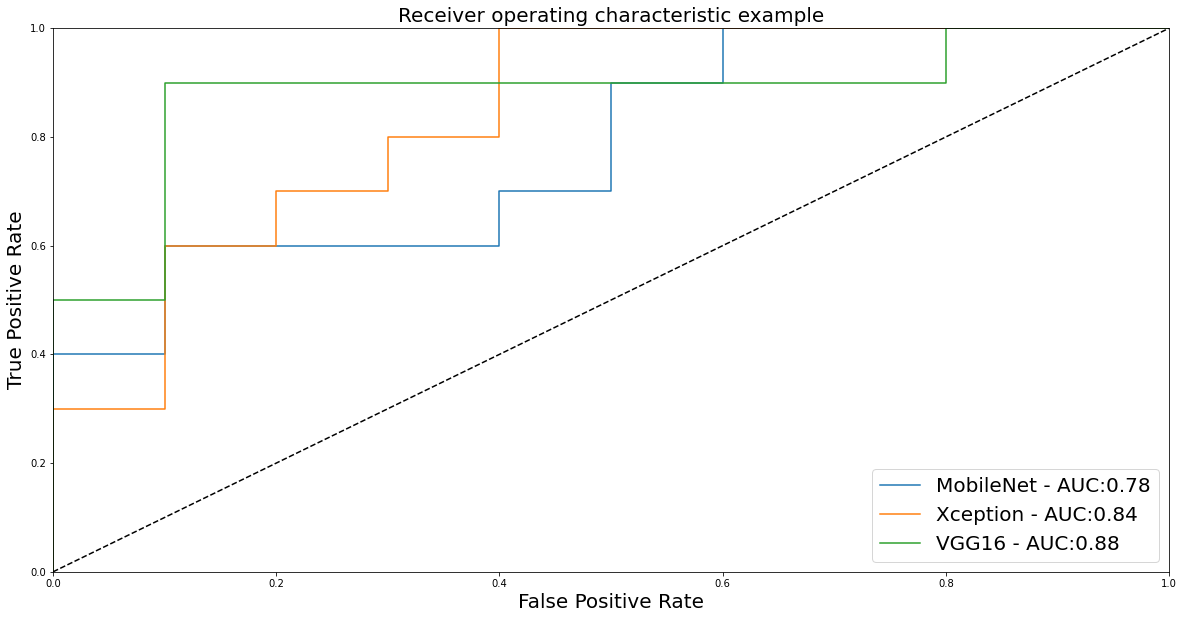

In [ ]:
plt.figure(figsize= [20,10])

for m, title, preimg in zip([model1, model2, model3], ['MobileNet', 'Xception', 'VGG16'],
            [preprocess_imgs1, preprocess_imgs2, preprocess_imgs3]):
  prob = m.predict(preimg)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, prob)
  plt.plot(fpr, tpr, label='%s - AUC:%.2f'%(title, auc(fpr, tpr)))

plt.legend(loc="lower right", fontsize = 20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver operating characteristic example', fontsize = 20)
plt.show()